In [279]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
#from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets
import igraph as ig
import random
from matplotlib.lines import Line2D


mpl.rcParams['figure.dpi'] = 200

#### antibody choice ####
#antibody = "9114"
antibody = "6261" 

antigens = ["H1", "H3", "FluB"] if antibody == "9114" else ["H1", "H9"]
L = (16 if antibody == "9114" else 11)
sequences_int = range(2**L)

def reachable(s, L):
    return [(s | 2**ii) for ii in range(L) if (s | 2**ii) > s]


In [268]:
if antibody == "9114":
    df = pd.read_csv("../../CR9114/Kd_meanbin/kd_processed/20210427_HA_unadj_fil_merg.csv",
                     dtype={"variant":"str"})
    df = df.rename(columns={"h1_mean": "H1_log10Kd", "h3_mean": "H3_log10Kd", "fluB_mean": "FluB_log10Kd",
                        "h1_sem": "H1_stelog10Kd", "h3_sem": "H3_stelog10Kd", "fluB_sem": "FluB_stelog10Kd"})
else:
    df = pd.read_csv("../../CR6261/Kd_meanbin/kd_processed/20210323_6261_HA_unadj_fil_merg.csv",
                     dtype={"variant":"str"})
    df = df.rename(columns={"h1_mean": "H1_log10Kd", "h9_mean": "H9_log10Kd",
                        "h1_sem": "H1_stelog10Kd", "h9_sem": "H9_stelog10Kd"})


# for ag in antigens:
#     df[f"{ag}_log10Kd"] = -df[f"{ag}_log10Kd"]
    #df.loc[df[f"{ag}_log10Kd"].isna(), f"{ag}_log10Kd"] = -6 if ag != "H1" else -7
    #df[f"{ag}_nonbinding"] = df[f"{ag}_log10Kd"] > (-6.1 if ag != "H1" else -7.1)
df["variant_int"] = df.variant.apply(lambda x: int(x, 2))

df = df.set_index("variant_int").reindex(range(0, 2**L)).reset_index()
sequences_int = range(0,2**L)
for s in df.loc[df['variant'].isna()]['variant_int']: 
    #print(s)
    if antibody == '6261':
        #print(f'{s:b}'.zfill(11))
        df.at[s, 'variant'] = f'{s:b}'.zfill(11)
    elif antibody == '9114':
        df.at[s, 'variant'] = f'{s:b}'.zfill(16)
    
for ii in range(16):
    df[f"mutation_{ii+1}"] = df.variant.str[ii] == '1'



In [269]:
df

,variant_int,variant,repa,repb,repc,H1_log10Kd,H1_stelog10Kd,repx,repy,repz,...,mutation_7,mutation_8,mutation_9,mutation_10,mutation_11,mutation_12,mutation_13,mutation_14,mutation_15,mutation_16
0,0,00000000000,7.000000,7.000000,7.000000,7.000000,0.000000,7.000000,7.000000,7.000000,...,False,False,False,False,False,False,False,False,False,False
1,1,00000000001,7.000000,7.000000,7.000000,7.000000,0.000000,7.000000,7.000000,7.000000,...,False,False,False,False,True,False,False,False,False,False
2,2,00000000010,7.000000,7.000000,7.000000,7.000000,0.000000,7.000000,7.000000,7.000000,...,False,False,False,True,False,False,False,False,False,False
3,3,00000000011,7.000000,7.000000,7.000000,7.000000,0.000000,7.000000,7.000000,7.000000,...,False,False,False,True,True,False,False,False,False,False
4,4,00000000100,7.000000,7.000000,7.000000,7.000000,0.000000,7.000000,7.000000,7.000000,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,2043,11111111011,9.435500,9.454886,9.510407,9.466931,0.015872,9.987392,9.993227,10.034566,...,True,True,False,True,True,False,False,False,False,False
2044,2044,11111111100,9.459939,9.467688,9.548492,9.492040,0.020022,10.147012,9.994343,10.075380,...,True,True,True,False,False,False,False,False,False,False
2045,2045,11111111101,9.497226,9.464661,9.543185,9.501691,0.016106,10.139807,10.032840,10.077313,...,True,True,True,False,True,False,False,False,False,False
2046,2046,11111111110,9.455344,9.434693,9.500465,9.463500,0.013732,10.078403,10.009879,10.072570,...,True,True,True,True,False,False,False,False,False,False


## Draw layout

In [321]:
# read data into graph


fitnesses = {}
for a in antigens:
    fitnesses[a] = (df.set_index("variant_int")[f"{a}_log10Kd"]).to_dict()

#print(len(fitnesses["H1"]))    
# construct plot
# stoid = dict(zip(fitnesses["H1"], range(len(fitnesses["H1"]))))
# print(stoid.items())
# idtos = dict(zip(range(len(fitnesses["H1"])), fitnesses["H1"]))

g = ig.Graph()
vertices = [s for s in sequences_int if ~np.isnan(fitnesses["H1"][s])]
#print(len(vertices))
g.add_vertices([str(s) for s in vertices])
#print(g.vcount())

    
# sys.exit()
# for s in vertices:
#     for t in reachable(s,L):
#         if t in vertices:
#             print(s,t)
#             g.add_edges([(s,t)])
g.add_edges([(str(s),str(t)) for s in vertices for t in reachable(s, L) if t in vertices])


#### weight choices ####
# H1 only
g.es["weight"] = [1/(0.01 + np.abs(fitnesses["H1"][t] - fitnesses["H1"][s]) ) # weight
                            for s in vertices
                  for t in reachable(s, L) if t in vertices]

# all antigens
# g.es["weight"] = [1/(0.01 + sum([np.abs(fitnesses[a][t] - fitnesses[a][s]) for a in fitnesses])) # weight
#                             for s in vertices
#                   for t in reachable(s, L) if t in vertices]
########################

g.vs["endpoints"] = [(s == 0 or s == len(sequences_int)-1) for s in sequences_int]



In [336]:
# draw the layout

# generate seed
if antibody == '9114':
    random.seed(21191)
elif antibody == '6261':
    random.seed(62611) 
seed = np.empty((len(vertices),2))
for i in range(len(vertices)):
    xcoord = random.uniform(-100,100)
    ycoord = random.uniform(-100,100)
    seed[i,:] = [xcoord,ycoord]
    
# create layout
layout = g.layout_drl(weights='weight',seed=seed)

# update df
coord =  np.array(layout.coords)
#print(coord)
xcoord = {vertices[i]:-1.0*coord[i, 1] for i in range(len(vertices))}
ycoord = {vertices[i]:coord[i, 0] for i in range(len(vertices))}
df["fdl_x"] = df.variant_int.map(xcoord)
df["fdl_y"] = df.variant_int.map(ycoord)



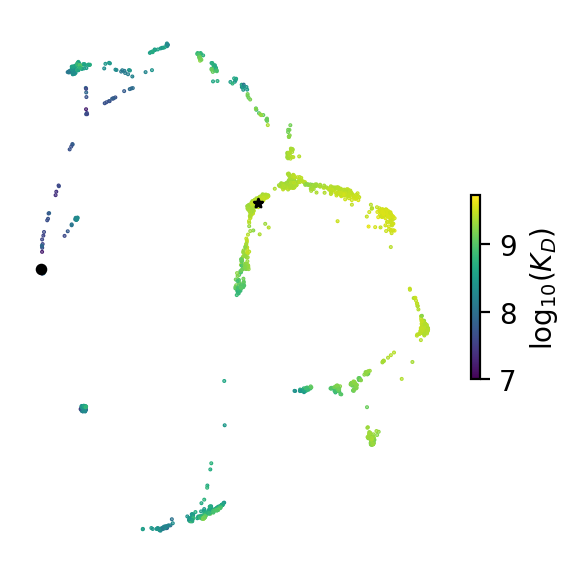

In [346]:
# binders = df.loc[df['FluB_log10Kd'] < -6.0]

fig, ax = plt.subplots(figsize=(3,3))
sc = ax.scatter(x=df.fdl_x, y=df.fdl_y,
           s=0.2, c=df.H1_log10Kd, alpha=1)
plt.colorbar(sc,fraction=0.02,label=r"$\log_{10}(K_D)$")
# ax.scatter(x=-1*binders.fdl_x, y=-1*binders.fdl_y,
#            s=0.2, c=-binders.FluB_log10Kd, alpha=1)
ax.scatter(x=df[df.variant == "0"*L].fdl_x, y=df[df.variant == "0"*L].fdl_y,
           s=10, c='black', alpha=1, marker="o")
ax.scatter(x=df[df.variant == "1"*L].fdl_x, y=df[df.variant == "1"*L].fdl_y,
           s=10, c="black", alpha=1, marker="*")
ax.set_aspect('equal')
ax.set_axis_off()
#ax.set_title(r'$\log_{10}(K_d)\ \mathrm{H1}$');
plt.tight_layout()
#plt.savefig('images/fdl_FluB.png',dpi=300)
plt.show()

In [341]:
if antibody == '9114':
    df.to_csv("20210430_fdl_9114.csv",index=False)
elif antibody == '6261':
    df.to_csv("20210504_fdl_6261.csv",index=False)
    

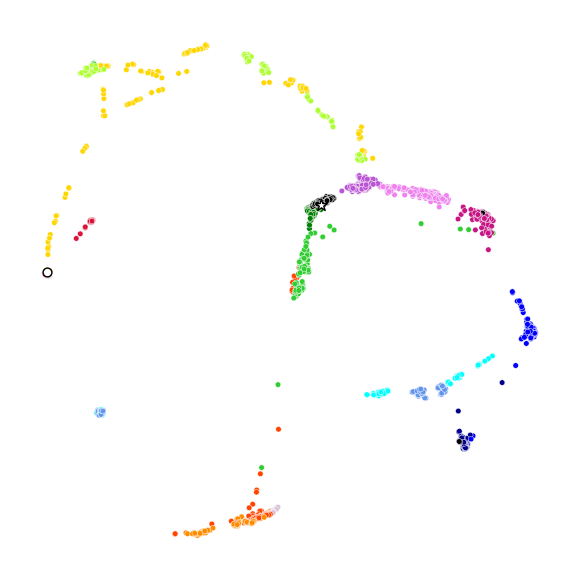

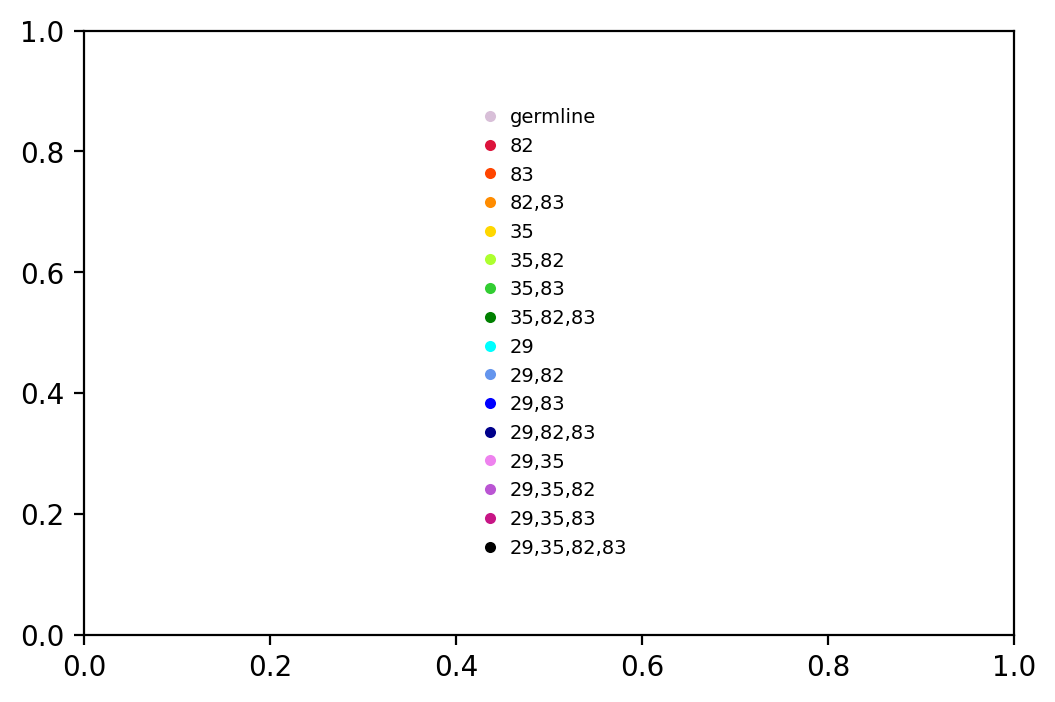

In [338]:
# color the landscape by the 4 focal mutations

mutation_lookat = [1,2,6,7]
fixed_mutations = {} 

namedict = {'germline':'germline','1':'29','2':'35','6':'82','7':'83'}

order = ['germline','6','7','6,7','2','2,6','2,7','2,6,7',
         '1','1,6','1,7','1,6,7','1,2','1,2,6','1,2,7','1,2,6,7']
# order = ['germline','6','7','6,7','1','1,6','1,7','1,6,7',
#         '2','2,6','2,7','2,6,7','1,2','1,2,6','1,2,7','1,2,6,7']

labels = [','.join([namedict[i] for i in x.split(',')]) for x in order]

colordict = {'gray':'#808080','darkolivegreen':'#556b2f','maroon2':'#7f0000','darkslateblue':'#483d8b',
            'green':'#008000','mediumseagreen':'#3cb371','darkkhaki':'#bdb76b','peru':'#cd853f',
             'lightseagreen':'#20b2aa','darkblue':'#00008b','limegreen':'#32cd32','darkmagenta':'#8b008b',
             'maroon3':'#b03060','orangered':'#ff4500','darkorange':'#ff8c00','lime':'#00ff00',
             
             'mediumspringgreen':'#00fa9a','blueviolet':'#8a2be2','crimson':'#dc143c','blue':'#0000ff',
             'greenyellow':'#adff2f','thistle':'#d8bfd8','fuchsia':'#ff00ff','salmon':'#fa8072',
             'laserlemon':'#ffff54','cornflower':'#6495ed','deeppink':'#ff1493','mediumslateblue':'#7b68ee',
             'violet':'#ee82ee','lightskyblue':'#87cefa','aquamarine':'#7fffd4','bisque':'#ffe4c4',
            
            'gold':'gold','mediumorchid':'mediumorchid','black':'black','mediumvioletred':'mediumvioletred',
            'cyan':'cyan','darkcyan':'darkcyan'}

palette = ['thistle','crimson','orangered',
           'darkorange','gold','greenyellow','limegreen','green',
            'cyan','cornflower','blue','darkblue',
           'violet','mediumorchid','mediumvioletred','black'] 
    
import matplotlib.colors as c

def _label(s, mut_lookat, fixed):
    for a in fixed:
        if s[a-1] != fixed[a]:
            return np.nan#"empty"
    lab = ""
    for a in mut_lookat:
        if s[a-1] == "1":
            lab += f"{a},"
    if lab == "":
        lab = "germline"
    else:
        lab = lab[:-1]
    return lab

#            'bisque','mediumspringgreen','salmon','lightskyblue','mediumslateblue',
#             'gray','darkkhaki','maroon2','peru',
#            'orangered','gold','limegreen','darkolivegreen',
#             'mediumseagreen','darkcyan',,'darkslateblue',
#            'darkblue','darkmagenta','blueviolet','black'
            
#             ]


hue = [_label(s, mutation_lookat, fixed_mutations) for s in df.variant]


plt.figure(figsize=(3,3)) 
ax = plt.subplot(111)
# ax.scatter(x=df.fdl_x_new, y=df.fdl_y_new,
#            s=.8, c='grey', alpha=0.2)
sns.scatterplot(x=df.fdl_x, y=df.fdl_y, 
                hue=hue, s=4, 
                ax=ax,palette=[colordict[x] for x in palette],hue_order=order,edgecolors='none',legend=None)

ax.scatter(x=df[df.variant == "0"*L].fdl_x, y=df[df.variant == "0"*L].fdl_y,
           s=10, facecolor='w',edgecolor='k',linewidth=0.5, alpha=1, marker="o")
ax.scatter(x=df[df.variant == "1"*L].fdl_x, y=df[df.variant == "1"*L].fdl_y,
           s=20,facecolor='w',edgecolor='k',linewidth=0.5, alpha=1, marker="*")

#ax.set_aspect('equal')
#ax.legend(bbox_to_anchor=(0.85, 1.0), loc='upper left',ncol=2)
ax.set_axis_off()

plt.tight_layout()
#plt.savefig('images/landscape_focal4.pdf')
plt.show()


legend_elements = []
for i in range(len(order)):
    legend_elements.append(Line2D([0], [0], marker='o', color='w', label=labels[i],
                                  markerfacecolor=colordict[palette[i]], markersize=5))

fig, ax = plt.subplots()
legendfig = ax.legend(handles=legend_elements, loc='center',ncol=1,framealpha=1, frameon=False,
                      fontsize=7,handletextpad=0)

plt.show()


def export_legend(legend, filename):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    #fig.savefig(filename, bbox_inches=bbox,transparent=True)

export_legend(legendfig,'images/landscape_focal4_leg.pdf')


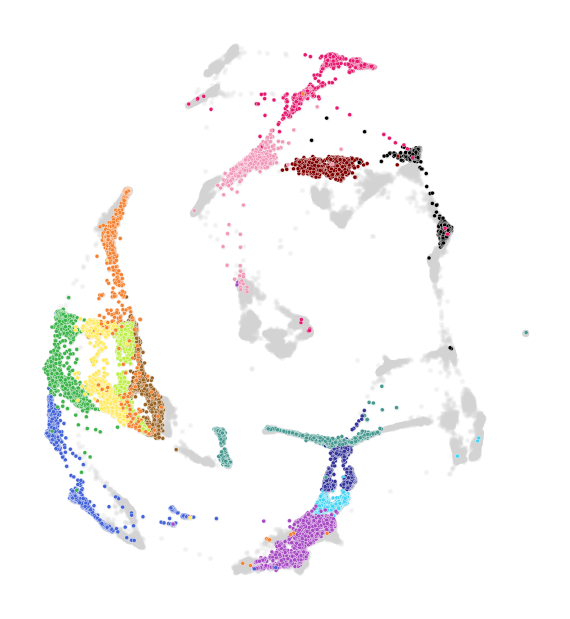

In [118]:
colordict = {'red':'#e6196e', 'green':'#3cb44b', 'yellow':'#ffe119', 'blue':'#4363d8', 
             'orange':'#f58231', 'cyan':'#42d4f4', 'magenta':'#f032e6', 'pink':'#fabed4', 
             'teal':'#469990', 'lavender':'#dcbeff', 'brown':'#9A6324', 'beige':'#fffac8', 
             'maroon':'#800000', 'mint':'#aaffc3', 'navy':'#000075', 'black':'#000000','white':'#ffffff',
             'olive':'#808000','lime':'#bfef45','purple':'#911eb4',
            'darkbeige':'#ccc8a0','lightyellow':'#ffea5e','lightnavy':'#333399','lightpurple':'#a74bc3',
            'lightmagenta':'#f35beb','darkpink':'#f299b9',
            'lightgrey':'lightgrey','darkgrey':'darkgrey'} #'red':'#e6194B'

mutation_lookat = [4,6,9]
fixed_mutations = {1:"0",10:"0"} #

mutation_lookat2 = [1,4,10]
fixed_mutations2 = {9:"0",6:"0"} #

def _label(s, mut_lookat, fixed):
    for a in fixed:
        if s[a-1] != fixed[a]:
            return np.nan#"empty"
    lab = ""
    for a in mut_lookat:
        if s[a-1] == "1":
            lab += f"{a},"
    if lab == "":
        lab = "germline"
    else:
        lab = lab[:-1]
    return lab

hue = [_label(s, mutation_lookat, fixed_mutations) for s in df.variant]
hue2 = [_label(s, mutation_lookat2, fixed_mutations2) for s in df.variant]

order_1 = ['germline','','4','6','9','','4,6','4,9','6,9','','4,6,9']
labels_1 = ['germline','57','65','82','57,65','57,82','65,82','57,65,82']
palette_1 = ['lightyellow','white','lime','green','lightpurple','white','teal','cyan','blue','white','lightnavy']


order_2 = ['germline','','1','4','10','','1,4','1,10','4,10','','1,4,10']
labels_2 = ['germline','30','57','83','30,57','30,83','57,83','30,57,83']
palette_2 = ['lightyellow','white','orange','lime','darkpink','white','brown','red','maroon','white','black']


plt.figure(figsize=(3.2,3.2)) #plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [4, 1]})
ax = plt.subplot(111)
ax.scatter(x=-1*df.fdl_x, y=-1*df.fdl_y,
           s=.8, c='lightgrey', alpha=0.2)
sns.scatterplot(x=-1*df.fdl_x, y=-1*df.fdl_y, 
                hue=hue, s=2, #s=(-df.H1_log10Kd-6.9)/3.0*10,
                ax=ax,palette=[colordict[x] for x in palette_1],hue_order=order_1,edgecolors='none')
sns.scatterplot(x=-1*df.fdl_x, y=-1*df.fdl_y, 
                hue=hue2, s=2, #s=(-df.H1_log10Kd-6.9)/3.0*10,
                ax=ax,palette=[colordict[x] for x in palette_2],hue_order=order_2,edgecolors='none')

ax.set_aspect('equal')

# label_list = []
# for t in ax.get_legend_handles_labels():
#     label_list.append(t)
    
# new_handle_list = []
# new_label_list = []
# for i in range(len(label_list[0])):
#     if i == 8 or i == 10:
#         continue
#     else:
#         new_handle_list.append(label_list[0][i])
#         new_label_list.append(labels_all[i])    
    
ax.get_legend().remove()
#ax.legend(handles=new_handle_list,labels=new_label_list,bbox_to_anchor=(1.05, 1.0), loc='upper left')

#ax.set_title("Mutation " + ",".join([f"{a}" for a in fixed_mutations]) + " fixed")
ax.set_axis_off()
#sns.violinplot(x=hue, y=-df.H1_log10Kd, ax=axes[1])
#axes[1].set_ylim([9,9.75])

plt.tight_layout()
#plt.savefig('images/landscape_violincolors.png')
plt.show()


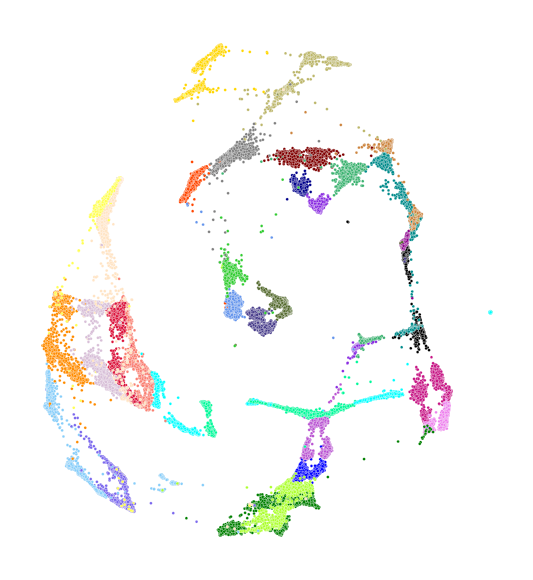

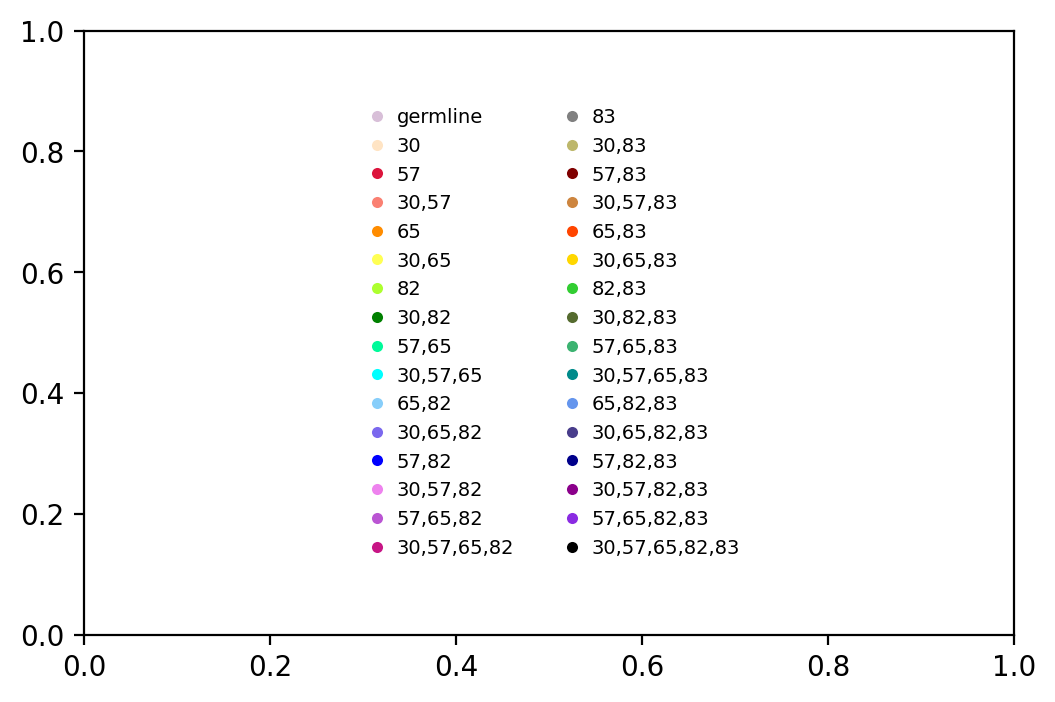

In [119]:
# color the landscape by the 5 focal mutations

mutation_lookat = [1,4,6,9,10]
fixed_mutations = {} 

namedict = {'germline':'germline','1':'30','4':'57','6':'65','9':'82','10':'83'}

order = ['germline','1','4','1,4','6','1,6','9','1,9','4,6','1,4,6','6,9','1,6,9','4,9','1,4,9','4,6,9','1,4,6,9',
        '10','1,10','4,10','1,4,10','6,10','1,6,10','9,10','1,9,10','4,6,10','1,4,6,10','6,9,10','1,6,9,10','4,9,10','1,4,9,10','4,6,9,10','1,4,6,9,10']
labels = [','.join([namedict[i] for i in x.split(',')]) for x in order]

colordict = {'gray':'#808080','darkolivegreen':'#556b2f','maroon2':'#7f0000','darkslateblue':'#483d8b',
            'green':'#008000','mediumseagreen':'#3cb371','darkkhaki':'#bdb76b','peru':'#cd853f',
             'lightseagreen':'#20b2aa','darkblue':'#00008b','limegreen':'#32cd32','darkmagenta':'#8b008b',
             'maroon3':'#b03060','orangered':'#ff4500','darkorange':'#ff8c00','lime':'#00ff00',
             
             'mediumspringgreen':'#00fa9a','blueviolet':'#8a2be2','crimson':'#dc143c','blue':'#0000ff',
             'greenyellow':'#adff2f','thistle':'#d8bfd8','fuchsia':'#ff00ff','salmon':'#fa8072',
             'laserlemon':'#ffff54','cornflower':'#6495ed','deeppink':'#ff1493','mediumslateblue':'#7b68ee',
             'violet':'#ee82ee','lightskyblue':'#87cefa','aquamarine':'#7fffd4','bisque':'#ffe4c4',
            
            'gold':'gold','mediumorchid':'mediumorchid','black':'black','mediumvioletred':'mediumvioletred',
            'cyan':'cyan','darkcyan':'darkcyan'}

palette = ['thistle','bisque','crimson','salmon',
           'darkorange','laserlemon','greenyellow','green',
            'mediumspringgreen','cyan','lightskyblue','mediumslateblue',
           'blue','violet','mediumorchid','mediumvioletred',
             
            
            
            'gray','darkkhaki','maroon2','peru',
           'orangered','gold','limegreen','darkolivegreen',
            'mediumseagreen','darkcyan','cornflower','darkslateblue',
           'darkblue','darkmagenta','blueviolet','black'
            
            ]


hue = [_label(s, mutation_lookat, fixed_mutations) for s in df.variant]

plt.figure(figsize=(3,3)) 
ax = plt.subplot(111)
# ax.scatter(x=df.fdl_x_new, y=df.fdl_y_new,
#            s=.8, c='grey', alpha=0.2)
sns.scatterplot(x=-1*df.fdl_x, y=-1*df.fdl_y, 
                hue=hue, s=1, 
                ax=ax,palette=[colordict[x] for x in palette],hue_order=order,edgecolors='none',legend=None)

ax.set_aspect('equal')
#ax.legend(bbox_to_anchor=(0.85, 1.0), loc='upper left',ncol=2)
ax.set_axis_off()

plt.tight_layout()
#plt.savefig('images/landscape_focal5.png')
plt.show()


legend_elements = []
for i in range(len(order)):
    legend_elements.append(Line2D([0], [0], marker='o', color='w', label=labels[i],
                                  markerfacecolor=colordict[palette[i]], markersize=5))

fig, ax = plt.subplots()
legendfig = ax.legend(handles=legend_elements, loc='center',ncol=2,framealpha=1, frameon=False,
                      fontsize=7,handletextpad=0)

plt.show()


def export_legend(legend, filename):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    #fig.savefig(filename, bbox_inches=bbox,transparent=True)

export_legend(legendfig,'images/landscape_focal5_leg.pdf')



In [ ]:
mutation_lookat = [1, 2, 6, 8, 7]
fixed_mutations = {8: "1"}

def _label(s, mut_lookat, fixed):
    for a in fixed:
        if s[a-1] == fixed[a]:
            return np.nan#"empty"
    lab = ""
    for a in mut_lookat:
        if s[a-1] == "1":
            lab += f"{a},"
    if lab == "":
        lab = "-"
    else:
        lab = lab[:-1]
    return lab


fig, axes = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [4, 1]})
hue = [_label(s, mutation_lookat, fixed_mutations) for s in df.variant]
sns.scatterplot(x=df.fdl_x, y=df.fdl_y, 
                hue=hue,
                s=1, ax=axes[0])
axes[0].set_aspect('equal')
axes[0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
axes[0].set_title("Mutation " + ",".join([f"{a}" for a in fixed_mutations]) + " fixed")
axes[0].set_axis_off()
sns.violinplot(x=hue, y=-df.H1_log10Kd, ax=axes[1])
plt.show()

In [88]:
# read data into graph
    
# construct plot
stoid_H3 = dict(zip(fitnesses["H3"], range(len(fitnesses["H3"]))))
#idtos_H3 = dict(zip(range(len(fitnesses["H3"])), fitnesses["H3"]))
g_H3 = ig.Graph()
vertices_H3 = [s for s in sequences_int if s in fitnesses["H3"] and not np.isnan(fitnesses["H3"][s])]
g_H3.add_vertices([stoid_H3[s] for s in vertices_H3])
for s in vertices_H3:
    #print(reachable(s,L))
    for t in reachable(s,L):
        if t == s: continue
        if t in vertices_H3:
            if not g_H3.vs.find(name=stoid_H3[t]) or not g_H3.vs.find(name=stoid_H3[s]):
                print(s,t)
            g_H3.add_edges([(stoid_H3[s],stoid_H3[t])])
# g_H3.add_edges([(stoid_H3[s],stoid_H3[t]) for s in vertices_H3 
#               for t in reachable(s, L) if t in vertices_H3])


#### weight choices ####
# H3 only
g_H3.es["weight"] = [1/(0.01 + np.abs(fitnesses["H3"][t] - fitnesses["H3"][s]) ) # weight
                            for s in vertices_H3
                  for t in reachable(s, L) if t in vertices_H3]

# all antigens
# g.es["weight"] = [1/(0.01 + sum([np.abs(fitnesses[a][t] - fitnesses[a][s]) for a in fitnesses])) # weight
#                             for s in vertices
#                   for t in reachable(s, L) if t in vertices]
########################

g_H3.vs["endpoints"] = [(s == 0 or s == len(sequences_int)-1) for s in sequences_int]



InternalError: Error at src/graph/type_indexededgelist.c:269: cannot add edges. -- Invalid vertex id

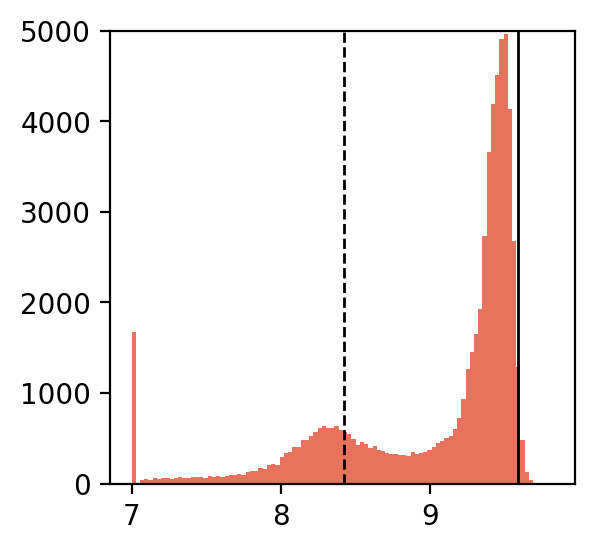

In [164]:
plt.figure(figsize=(3,3))
plt.hist(-1.0*df['H1_log10Kd'],bins=100,color='#e8735c')
germ_pheno = -1.0*float(df.loc[df['variant']=='0000000000000000']['H1_log10Kd'])
som_pheno = -1.0*float(df.loc[df['variant']=='1111111111111111']['H1_log10Kd'])
#print(germ_pheno,som_pheno)
plt.plot([germ_pheno,germ_pheno],[0,6000],'k--',linewidth=1.0)
plt.plot([som_pheno,som_pheno],[0,6000],linewidth=1.0,color='black')
plt.ylim([0,5000])
plt.show()